# Introduction
In this project we will be webscraping the Zomato website. This website contains information about popular restaurants. We will collect data on the GTA and using various data visualization tools.

This project is done in collaboration with Charles Qin

## Import Python Modules
Here we will import the relevant libraries.

In [1]:
from selenium import webdriver # For webscraping
import re # For regex manipulation
import pandas as pd # Loading and manipulating data
import folium # For interactive maps
from geopy.geocoders import Nominatim # To get location coordinate informations
import time
import matplotlib.pyplot as plt # For plotting data 
import numpy as np # Performing various operations on data
import seaborn as sns
sns.set(style="ticks", color_codes=True) # for plot styling
%matplotlib inline

## Setup Web Scraping
- Define functions that will help us clean and manipulate our data
- We will use the selenium library to webscrape the Zomato website

Set Up Driver

In [2]:
driver = webdriver.Chrome('/Users/saifrahman/Downloads/chromedriver')

Go to zomato website

In [3]:
driver.get('https://www.zomato.com/toronto')

Scrape the website ciy and district tags and store in a list

In [4]:
city_tags = driver.find_elements_by_tag_name('h5')
cities = [tag.text.split(' (')[0] for tag in city_tags]

Create a list of the various establishments 

In [5]:
establishments = ['Quick Bites','Casual Dining','Café','Bar','Dessert Parlor','Bakery',\
                  'Beverage Shop','Fast Casual','Fast Food','Fine Dining']

Create a list for the Toronto districts

In [6]:
toronto_districts = ['Entertainment District','Kensington-Chinatown','Yonge & Eglinton','The Danforth',\
                     'Fashion District','The Annex','Yorkville','St. Lawrence','Financial District',\
                     'Leslieville','Discovery District','Grange Park','The Beaches','East Danforth','Downtown Yonge']

Define various functions to aid in web scrape and data cleaning

In [7]:
def clean_cuisine(city):
    """
    Takes in a dataframe containing a column named 'Cuisine' and mutates that column by narrowing down cuisine types.
    """
    city['Cuisine'] = city['Cuisine'].apply(lambda x: x.replace('Sushi','Japanese').replace('Ramen', 'Japanese') \
        .replace('Hakka Chinese', 'Chinese').replace('Cantonese', 'Chinese').replace('Tea', 'Cafe') \
        .replace('icecream', 'Desserts').replace('Coffe and Tea', 'Cafe').replace('Pizza', 'Fast Food') \
        .replace('Juices', 'Beverages').replace('Bubble Tea', 'Beverages').replace('Drinks Only', 'Bar Food') \
        .replace('Asian Fusion', 'Asian').replace('Burger', 'American').replace('Steak', 'Steakhouse') \
        .replace('Steakhouses', 'Steakhouse').replace('Taiwanese', 'Chinese').replace('Northen Indian', 'Indian') \
        .replace('Fish and Chips', 'British').replace('Frozen Yogurt', 'Desserts').replace('Donuts', 'Desserts') \
        .replace('Grill', 'BBQ').replace('Northen Chinese', 'Chinese').replace('Fusion', '') \
        .replace('Salad', 'Healthy Food').replace('Vegetarian', 'Healthy Food').replace('Sandwich', 'American') \
        .replace('Ethiopian', 'African').replace('Moroccan', 'African').replace('Salvadorean', 'Latin American') \
        .replace('Cajun', 'American').replace('Tapas', 'Spanish').replace('Canadian', 'American') \
        .replace('Sichuan', 'Chinese').replace('Mongolian', 'Chinese').replace('Hot Pot', 'Chinese') \
        .replace('Eastern European', 'European').replace('Pub Food', 'Bar Food').replace('Tex-Mex', 'American') \
        .replace('Cuban', 'Caribbean').replace('Greek', 'Mediterranean').replace('Jamaican', 'Caribbean') \
        .replace('Patisserie', 'Desserts').replace('Dim Sum', 'Chinese').replace('Hong Kong Style', 'Chinese') \
        .replace('Yunnan', 'Chinese').replace('Argentine', 'Latin America').replace('West Indian', 'Indian') \
        .replace('Nepalese', 'Asian').replace('Tibetan', 'Asian').replace('Xinjiang', 'Chinese').replace('Bagels', 'Bakery') \
        .replace('Georgian', 'European').replace('Moldovan', 'European').replace('Guyanese', 'Latin American') \
        .replace('Kebab', 'Middle Eastern').replace('Nigerian', 'African').replace('Colombian', 'Latin American') \
        .replace('Peruvian', 'Latin American').replace('Shanghai', 'Chinese').replace('Somali', 'African') \
        .replace('Afghani','Afghan').replace('Ice Cream','Desserts').split(', ')[0])

In [8]:
def gotocity(city, page=1):
    '''
    Takes a city and page number (1 by default), and returns a string url with fitted parameters.
    '''
    city = city.lower().replace(' &','').replace('.','').replace(' ','-')
    return f'https://www.zomato.com/toronto/{city}-restaurants?nearby=0&page={page}'

In [9]:
def clean_info(restaurant_info):
    '''
    Takes a string containing all restaurants info, removes information not required in webscrape, and returns a list
    containing key pieces of information as seperate items.
    '''
    rsplit = restaurant_info.strip().split('\n')
    try:
        rsplit.remove('')
    except:
        pass
    if rsplit[0] == 'View Menu':
        rsplit = rsplit[1:]
    if re.findall("1 more outlet in .*", rsplit[0]):
        rsplit = rsplit[3:]
    if re.findall("2 more outlets in .*", rsplit[0]):
        rsplit = rsplit[5:]
    if re.findall("[^2] more outlets in .*", rsplit[0]):
        rsplit = rsplit[6:]
    try:
        rsplit[0] = [e for e in rsplit[0].split(',') if e.title() in establishments][0]
    except:
        rsplit[0] = 'Other'
    return rsplit

In [10]:
def clean_address(address):
    '''
    Takes a full address, a returns only the street number and street name.
    '''
    try:
        postal_code = re.findall('[A-Za-z]\d[A-Za-z]\s\d[A-Za-z]\d',address)
        if len(postal_code) > 0:
            address = address.replace(' ' + postal_code[0],'')
        return re.findall("[0-9]{1,},? [a-zA-Z]+[^,]*", address.replace("'", ''))[0].replace(',','')
    except:
        return address

In [11]:
def get_coordinates(df):
    """
    Takes a dataframe, uses address and city column, and returns latitude and longitude coordinate points.
    """
    geolocator = Nominatim(user_agent="test")
    lats, longs = [],[]
    for row in df.iterrows():
        location = geolocator.geocode(row[1].Address.split(',')[0] + ', '+ row[1].City + ', Ontario, Canada')
        try:
            lats.append(location.latitude)
            longs.append(location.longitude)
        except:
            lats.append(None)
            longs.append(None)
    return lats, longs

In [12]:
def structure_data(restaurants):
    """
    Converts each city and district in all_cities (from webscrape) into a dataframe, and saves it into a csv file.
    Also adds the column city, representing the city the data represents.
    """
    for city in cities:
        city_name = city.lower().replace(' &','').replace('.','').replace(' ','-')
        temp_df = pd.DataFrame(restaurants[city])
        temp_df['City'] = city
        temp_df.to_csv(f'restaurant_data/{city_name}-restaurants.csv',index=False)

In [13]:
def get_data_dict():
    """
    Loads in relevant files into a dictionary where each key is the city name.
    """
    restaurant_dfs = {}
    for city in cities:
        city_name = city.lower().replace(' &','').replace('.','').replace(' ','-')
        restaurant_dfs[city] = pd.read_csv(f'restaurant_data/{city_name}-restaurants.csv')
    return restaurant_dfs

### Function for Selenium Web Scrape

In [14]:
%%time
def webscrape_zomato():
    """ 
    Web scrape Zomoto GTA area, and organize information into a dictionary, with city being key and value being a list of
    dictionaries, where each dictionary contains the relevant information for that restaurant
    """

    all_cities = {}

    for city in cities:
        all_cities[city] = []
        driver.get(gotocity(city))
        num_pages = int(driver.find_element_by_xpath('//*[@id="search-results-container"]/div[2]/div[1]/div[1]/div/b[2]').text) + 1
        for i in range(1,num_pages):
            url = gotocity(city, i)
            driver.get(url)
            restaurant_tags = driver.find_element_by_xpath('//*[@id="orig-search-list"]')
            restaurant_info = restaurant_tags.text.replace('ADVERTISEMENT','').split('\nCall\n')[:-1]
            for restaurant in restaurant_info:
                rsplit = clean_info(restaurant)
                try:
                    name = rsplit[1]
                except:
                    name = None
                try:
                    estab_type = rsplit[0]
                except:
                    estab_type = None
                try:
                    rating = float(rsplit[2])
                except:
                    rating = None
                try:
                    num_reviews = int(rsplit[3][1:-8].replace(',',''))
                except:
                    num_reviews = None        
                if not num_reviews:
                    address = rsplit[3]
                else:
                    address = rsplit[5]
                try:
                    cuisine = rsplit[rsplit.index('CUISINES:')+1]
                except:
                    cuisine = None
                try:
                    cost_for_two = float(rsplit[rsplit.index('COST FOR TWO:')+1].split('$')[1])
                except:
                    cost_for_two = None

                all_cities[city].append({'Name':name,'EstablishmentType':estab_type, 'Rating':rating, 'NumReviews':num_reviews, 
                                         'Address': address,'Cuisine':cuisine, 'CostForTwo':cost_for_two})
            time.sleep(0.5)
    return all_cities
all_cities = webscrape_zomato()

CPU times: user 2.25 s, sys: 213 ms, total: 2.46 s
Wall time: 23min 4s


## Data Cleaning and Manipulation

Save each city from the all_cities dictionary as a separate `.csv` file

In [229]:
structure_data(all_cities)

Get a dictionary containing dataframes for each city/district

In [230]:
city_dfs = get_data_dict()

Concatonate all city and district data into single dataframe

In [231]:
all_restaurants_df = pd.concat(list(city_dfs.values()),ignore_index=True)

In [232]:
all_restaurants_df

,Name,EstablishmentType,Rating,NumReviews,Address,Cuisine,CostForTwo,City
0,Johnny's Hamburgers,QUICK BITES,4.2,469.0,"2595 Victoria Park Avenue, Scarborough M1T 1A4",Burger,15.0,Scarborough
1,Fishman Lobster Clubhouse,CASUAL DINING,4.0,175.0,"Silver Star, 680 Silver Star Boulevard, Scarbo...","Seafood, Cantonese, Chinese",140.0,Scarborough
2,Le Cafe Michi,CASUAL DINING,4.2,209.0,"1802 Pharmacy Avenue, Scarborough M1T 1H6","Sushi, Japanese, Asian",55.0,Scarborough
3,Lamanna's Bakery,BAKERY,4.7,169.0,"6758 Kingston Road, Scarborough M1B 1G8","Bakery, Italian",25.0,Scarborough
4,Federick Restaurant,CASUAL DINING,4.2,228.0,"1920 Ellesmere Road, Scarborough M1H 2V6","Hakka Chinese, Chinese, Asian",30.0,Scarborough
...,...,...,...,...,...,...,...,...
9634,Golden Restaurant & Cafe,CAFÉ,NaN,NaN,"1375 Danforth Avenue, East Danforth","Middle Eastern, Cafe",NaN,East Danforth
9635,Harbour King,CASUAL DINING,NaN,NaN,"2344 Danforth Avenue, Toronto M4C 1K7",Chinese,30.0,East Danforth
9636,Cafe Cocoro,CAFÉ,NaN,NaN,"1989 Danforth Avenue, Toronto, ON M4C 1J7",Cafe,15.0,East Danforth
9637,Maple Cafe,CAFÉ,NaN,NaN,"5A Linsmore Crescent, Toronto M4J 4J5",Cafe,15.0,East Danforth


Clean all_restaurants_df address column and fill the nan values in cuisine

In [233]:
all_restaurants_df['Address'] = all_restaurants_df['Address'].apply(clean_address)
all_restaurants_df['Cuisine'] = all_restaurants_df['Cuisine'].fillna('N/A')
clean_cuisine(all_restaurants_df)

Check all_restaurants_df

In [234]:
all_restaurants_df.head()

,Name,EstablishmentType,Rating,NumReviews,Address,Cuisine,CostForTwo,City
0,Johnny's Hamburgers,QUICK BITES,4.2,469.0,2595 Victoria Park Avenue,American,15.0,Scarborough
1,Fishman Lobster Clubhouse,CASUAL DINING,4.0,175.0,680 Silver Star Boulevard,Seafood,140.0,Scarborough
2,Le Cafe Michi,CASUAL DINING,4.2,209.0,1802 Pharmacy Avenue,Japanese,55.0,Scarborough
3,Lamanna's Bakery,BAKERY,4.7,169.0,6758 Kingston Road,Bakery,25.0,Scarborough
4,Federick Restaurant,CASUAL DINING,4.2,228.0,1920 Ellesmere Road,Chinese,30.0,Scarborough


In [235]:
all_restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9639 entries, 0 to 9638
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               9639 non-null   object 
 1   EstablishmentType  9639 non-null   object 
 2   Rating             5724 non-null   float64
 3   NumReviews         5724 non-null   float64
 4   Address            9639 non-null   object 
 5   Cuisine            9639 non-null   object 
 6   CostForTwo         9150 non-null   float64
 7   City               9639 non-null   object 
dtypes: float64(3), object(5)
memory usage: 602.6+ KB


In [236]:
all_restaurants_df.describe()

,Rating,NumReviews,CostForTwo
count,5724.000000,5724.000000,9150.000000
mean,3.503809,36.108665,33.364699
std,0.442863,58.348071,23.673966
min,2.000000,4.000000,5.000000
25%,3.200000,8.000000,20.000000
50%,3.500000,17.000000,25.000000
75%,3.800000,42.000000,40.000000
max,4.900000,1260.000000,1240.000000


Let's also create a dataframe for the Toronto districts

In [237]:
toronto = all_restaurants_df[all_restaurants_df['City'].apply(lambda a: True if a in toronto_districts else False)]
toronto = toronto.rename(columns={'City':'District'})
toronto.reset_index(drop=True, inplace=True)

In [238]:
toronto.to_csv('restaurant_data/toronto_districts.csv')
toronto.head()

,Name,EstablishmentType,Rating,NumReviews,Address,Cuisine,CostForTwo,District
0,Salad King,CASUAL DINING,4.2,1260.0,340 Yonge Street,Thai,30.0,Downtown Yonge
1,Chipotle,FAST CASUAL,4.3,495.0,323 Yonge Street,American,30.0,Downtown Yonge
2,Barberian's Steakhouse And Tavern,FINE DINING,4.4,276.0,7 Elm Street,Steakhouse,160.0,Downtown Yonge
3,7 West Cafe,CAFÉ,4.3,299.0,7 Charles Street West,Cafe,45.0,Downtown Yonge
4,The 3 Brewers,CASUAL DINING,4.1,313.0,275 Yonge Street,American,65.0,Downtown Yonge


Now that we have a seperate dataframe for the Toronto districts, let's generalize our all_restaurants_df dataframe to the city `Toronto`.

In [239]:
all_restaurants_df['City'] = all_restaurants_df['City'].apply(lambda city: 'Toronto' if city in toronto_districts else city)
clean_cuisine(all_restaurants_df)
all_restaurants_df.to_csv('restaurant_data/gta_restaurants.csv')

In [240]:
all_restaurants_df.head(10)

,Name,EstablishmentType,Rating,NumReviews,Address,Cuisine,CostForTwo,City
0,Johnny's Hamburgers,QUICK BITES,4.2,469.0,2595 Victoria Park Avenue,American,15.0,Scarborough
1,Fishman Lobster Clubhouse,CASUAL DINING,4.0,175.0,680 Silver Star Boulevard,Seafood,140.0,Scarborough
2,Le Cafe Michi,CASUAL DINING,4.2,209.0,1802 Pharmacy Avenue,Japanese,55.0,Scarborough
3,Lamanna's Bakery,BAKERY,4.7,169.0,6758 Kingston Road,Bakery,25.0,Scarborough
4,Federick Restaurant,CASUAL DINING,4.2,228.0,1920 Ellesmere Road,Chinese,30.0,Scarborough
5,The Real McCoy,QUICK BITES,4.5,178.0,1033 Markham Road,Fast Food,25.0,Scarborough
6,Terry's Bar & Grill,CASUAL DINING,4.3,227.0,1920 Ellesmere Road,Bar Food,40.0,Scarborough
7,Diana's Oyster Bar And Grill,CASUAL DINING,4.1,119.0,2105 Lawrence Avenue E,Seafood,60.0,Scarborough
8,Perfect Chinese Restaurant,CASUAL DINING,4.0,148.0,4386 Sheppard Avenue East,Chinese,25.0,Scarborough
9,Gourmet Malaysia,CASUAL DINING,3.8,86.0,4466 Sheppard Avenue East,Malaysian,30.0,Scarborough


Create a dataframe by sorting all_restaurants_df by `Rating` and `NumReviews` and select the top 100

In [241]:
top100 = all_restaurants_df.sort_values(by=['Rating','NumReviews'],ascending=[False,False],ignore_index=True)[:100]

In [242]:
top100.to_csv('restaurant_data/top100restaurants.csv')

Add latitude and longitude columns using get_coordinates function

In [243]:
top100['Latitude'],top100['Longitude'] = get_coordinates(top100) # Takes ~1 minute to run

In [244]:
top100.head()

,Name,EstablishmentType,Rating,NumReviews,Address,Cuisine,CostForTwo,City,Latitude,Longitude
0,Pai,CASUAL DINING,4.9,615.0,18 Duncan Street,Thai,50.0,Toronto,43.647835,-79.388714
1,Jacob's and Co. Steakhouse,FINE DINING,4.9,316.0,12 Brant Street,Steakhousehouse,140.0,Toronto,43.645407,-79.398150
2,Seven Lives - Tacos Y Mariscos,QUICK BITES,4.9,310.0,69 Kensington Avenue,Mexican,25.0,Toronto,43.654539,-79.400822
3,Ravi Soups,QUICK BITES,4.9,238.0,322 Adelaide Street West,Sri Lankan,35.0,Toronto,43.647614,-79.391923
4,Bamiyan Kabob,QUICK BITES,4.9,104.0,7760 Markham Road,Middle Eastern,35.0,Markham,43.909778,-79.268105


## Data Visualization

Let's see the breakdown of all the cuisines in our dataframe

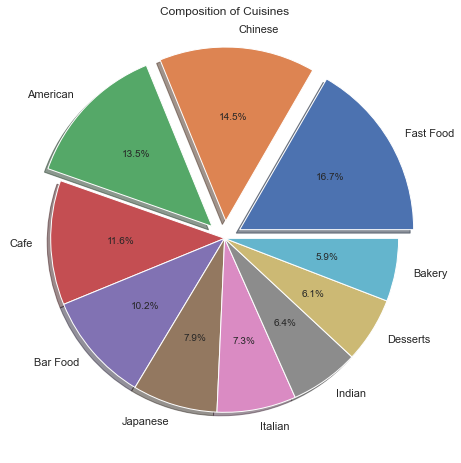

In [246]:
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(10,8))
cuisines = all_restaurants_df.groupby('Cuisine')['Cuisine'].count().nlargest(10)
cuisines = cuisines*100/sum(cuisines)
cuisines.values
ax.pie(cuisines.values,\
       autopct='%1.1f%%',shadow=True,\
      labels=cuisines.index, explode = (0.1,0.1,0.1,0,0,0,0,0,0,0))
ax.set_title('Composition of Cuisines');

Now let's see the breakdown of our establishment types

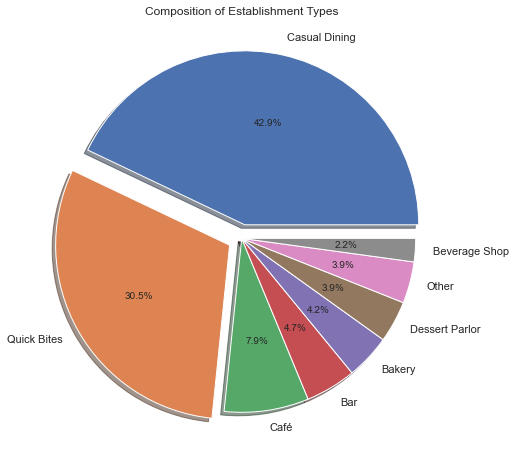

In [253]:
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(10,8))
estabtypes = all_restaurants_df.groupby('EstablishmentType')['EstablishmentType'].count().nlargest(8)
value_counts = {}
for x,y in zip(estabtypes.index,estabtypes.values):
    types = x.split(',')
    for etype in types:
        if etype in value_counts:
            value_counts[etype] += float(y)
        else:
            value_counts[etype] = float(y)   
ax.pie(pd.Series(value_counts.values())*100/sum(value_counts.values()),\
       explode = (0.08,0.08,0,0,0,0,0,0),
       autopct='%1.1f%%',shadow=True,\
      labels=[x.title() for x in value_counts.keys()])
ax.set_title('Composition of Establishment Types');

Let's look at the pricing spread for all our restaurants by city

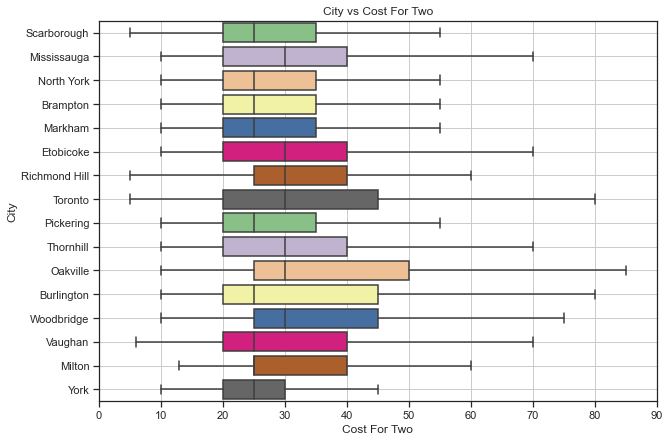

In [254]:
fig, ax = plt.subplots(figsize=(10,7))
f = sns.color_palette('Accent')
sns.boxplot(x="CostForTwo", y="City", data=all_restaurants_df, ax=ax, showfliers = False, palette=f)
ax.set_xlabel('Cost For Two')
ax.set_title('City vs Cost For Two');
ax.set(xticks=range(0,100,10))
plt.grid();

Let's create folium map using our top 100 restaurants dataframe. Here we'll use the restaurant name, latitude and longitude points

In [265]:
restaurant_map = folium.Map(location=[43.648744,-79.396944],zoom_start=9.5)
for x in top100.iterrows():
    if not np.isnan(x[1].Latitude):
        folium.Marker([x[1].Latitude, x[1].Longitude],
                 popup = f'{x[1].Name}').add_to(restaurant_map)
restaurant_map

Let's see the composition of cities in top100 dataframe

In [256]:
percentage_split = top100.groupby('City')['City'].count()/(len(top100))*100

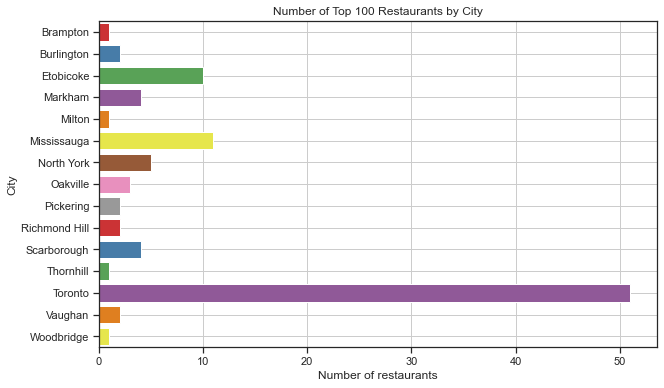

In [257]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=percentage_split.values, y=percentage_split.index,ax=ax,palette='Set1');
ax.set_title('Number of Top 100 Restaurants by City')
ax.set_xlabel('Number of restaurants')
plt.grid();

We can clearly see that Toronto dominates the restaurant industry in the GTA.

Lets see the spread of costs for the top 100 restaurants

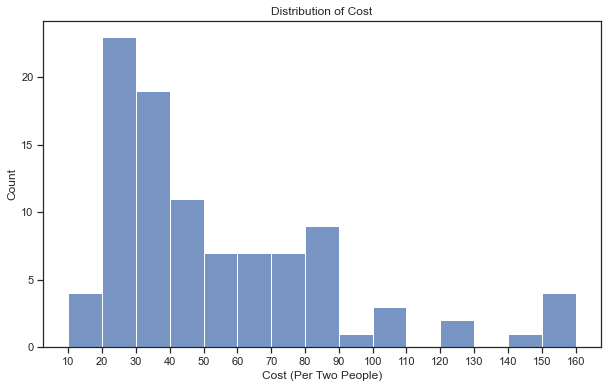

In [258]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=top100,x='CostForTwo',bins=list(range(10,170,10)),ax=ax)
ax.set_xticks(list(range(10,170,10)))
ax.set_title('Distribution of Cost')
ax.set_xlabel('Cost (Per Two People)');

Lets see the distribution of cuisines for the top 100 restaurants

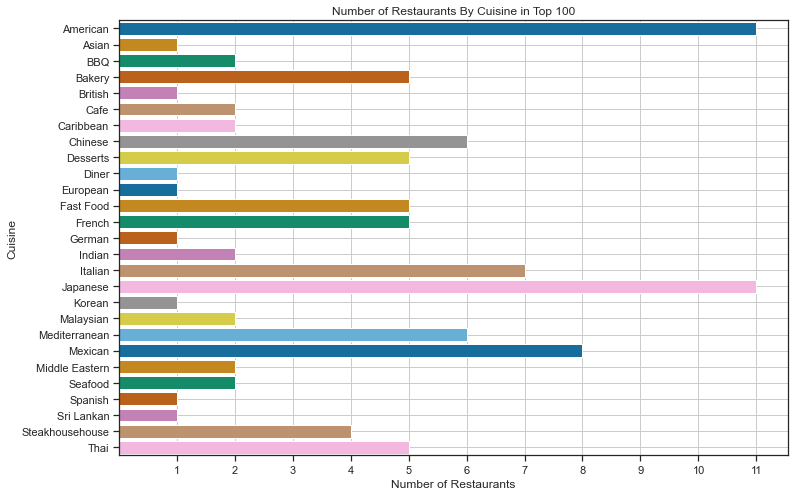

In [259]:
fig, ax = plt.subplots(figsize=(12,8))

cuisines = top100.groupby('Cuisine')['Cuisine'].count().index
counts = top100.groupby('Cuisine')['Cuisine'].count().values
f = sns.color_palette('colorblind')
sns.barplot(data=top100, y=cuisines, x=counts, orient='h', ax=ax, palette=f);
ax.set_xlabel('Number of Restaurants');
ax.set_title('Number of Restaurants By Cuisine in Top 100');
ax.set(xticks=range(1,12))
plt.grid();

Let's dig deeper into the Toronto districts

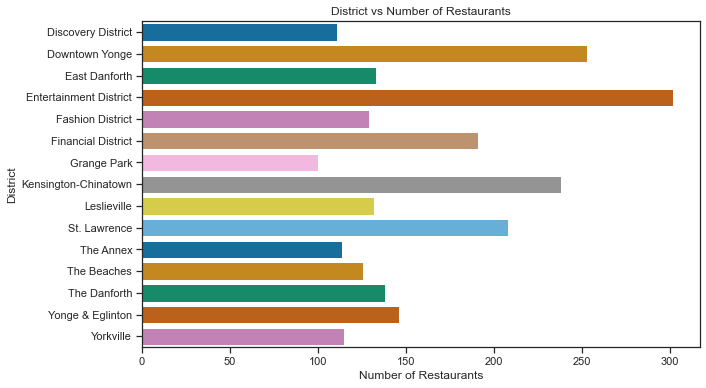

In [260]:
fig, ax = plt.subplots(figsize=(10,6))
districts = toronto.groupby('District')['District'].count()
sns.barplot(x = districts.values, y = districts.index,palette=sns.color_palette('colorblind'),ax=ax)
ax.set_xlabel('Number of Restaurants')
ax.set_title('District vs Number of Restaurants');

Let's also look at the pricing spread for the Toronto districts

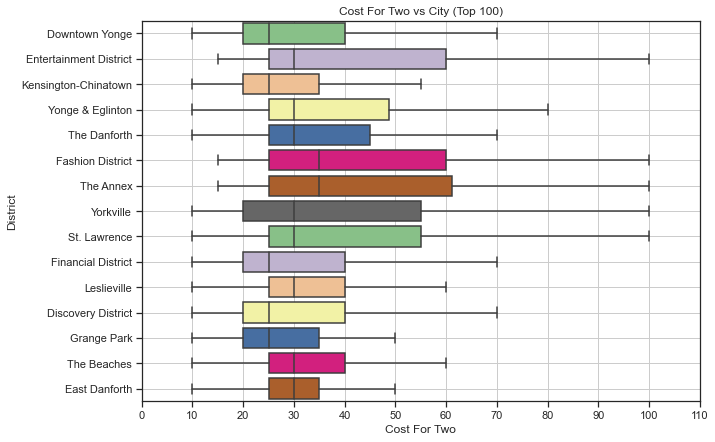

In [261]:
fig, ax = plt.subplots(figsize=(10,7))
f = sns.color_palette('Accent')
sns.boxplot(x="CostForTwo", y="District", data=toronto, ax=ax, showfliers = False, palette=f)
ax.set_xlabel('Cost For Two')
ax.set_title('Cost For Two vs City (Top 100)');
ax.set(xticks=range(0,120,10))
plt.grid();